### data augmentation on test image

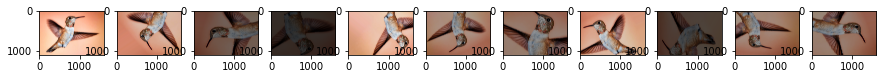

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

# load the image
img = load_img('test.jpg')
# convert to numpy array
data = img_to_array(img)

# expand dimension to one sample
samples = np.expand_dims(data, 0)

# create image data augmentation generator
datagen = ImageDataGenerator(width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True, vertical_flip=True,
                             rotation_range=90,
                             brightness_range=[0.2,1.0],
                             zoom_range=[0.5,1.0])
# prepare iterator
it = datagen.flow(samples, batch_size=1)

# define subplot
f, axs = plt.subplots(1,11,figsize=(15,15))
axs[0].imshow(samples[0].astype('uint8'))

# generate samples and plot
for i in range(10):
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	axs[i+1].imshow(image)
# show the figure
plt.show()


### cifar10

#### reduce and read data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import pickle

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [ ]:
!rm -rf cifar-10-batches-py

In [ ]:
!wget -c https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz -O - | tar -xz

--2021-05-06 13:06:53--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘STDOUT’

-                   100%[===================>] 162.60M  54.8MB/s    in 3.0s    

2021-05-06 13:06:56 (54.8 MB/s) - written to stdout [170498071/170498071]



In [ ]:
train = []
label = []
nums = [chr(ord('1')+i) for i in range(5)]
for i in nums:
  train.append(unpickle('/content/cifar-10-batches-py/data_batch_'+i)[b'data'].reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8"))
  label.append(unpickle('/content/cifar-10-batches-py/data_batch_'+i)[b'labels'])

train = np.vstack(train)
label = np.hstack(label)

In [ ]:
test = unpickle('/content/cifar-10-batches-py/test_batch')[b'data'].reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
test_label = np.array(unpickle('/content/cifar-10-batches-py/test_batch')[b'labels'])

In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

#### Noramlization and convert labels to one-hot vectors

In [ ]:
# Change to float datatype
train = train.astype('float32')
test = test.astype('float32')

# Noramlization from [0;255] to [0;1], Scale the data to lie between 0 to 1
train /= 255
test /= 255

# convert labels to one-hot vectors
from keras.utils import np_utils
label = np_utils.to_categorical(label)
test_label = np_utils.to_categorical(test_label)

#### reduce

In [ ]:
import random

c = []
d = []
for i, v in enumerate(label):
  if np.argmax(v)==3:
    c.append(i)
  elif np.argmax(v)==5:
    d.append(i)

c = random.sample(c, 4500)
d = random.sample(d, 4500)
label = np.delete(label, c+d, 0)
train = np.delete(train, c+d, 0)

In [ ]:
train.shape

(41000, 32, 32, 3)

In [ ]:
label.shape

(41000, 10)

In [ ]:
from sklearn.utils import shuffle
train, label = shuffle(train, label, random_state=0)

#### classification

In [ ]:
from keras.models import Sequential
from keras.utils import np_utils
from keras import layers

def create(nl=1, act='relu', opt='Adam', dcnv=True, drp=False, filter=[32,64,128], kernel=[3,3,3], eln=[128,64], drp_v = [0.3, 0.5]):
  model = Sequential()

  if dcnv:
    model.add(layers.Conv2D(filters=filter[0], kernel_size=kernel[0], padding='same', activation=act, input_shape=(32,32,3))) 
    model.add(layers.Conv2D(filters=filter[0], kernel_size=kernel[0], padding='same', activation=act))
  else:
    model.add(layers.Conv2D(filters=filter[0], kernel_size=(kernel[0]*2)-1, padding='same', activation=act, input_shape=(32,32,3)))
  model.add(layers.MaxPooling2D(pool_size=2))
  if drp:
    model.add(layers.Dropout(drp_v[0]))

  if dcnv:
    model.add(layers.Conv2D(filters=filter[1], kernel_size=kernel[1], padding='same', activation=act))
    model.add(layers.Conv2D(filters=filter[1], kernel_size=kernel[1], padding='same', activation=act))
  else:
    model.add(layers.Conv2D(filters=filter[1], kernel_size=(kernel[1]*2)-1, padding='same', activation=act))
  model.add(layers.MaxPooling2D(pool_size=2))
  if drp:
    model.add(layers.Dropout(drp_v[0]))

  if dcnv:
    model.add(layers.Conv2D(filters=filter[2], kernel_size=kernel[2], padding='same', activation=act))
    model.add(layers.Conv2D(filters=filter[2], kernel_size=kernel[2], padding='same', activation=act))
  else:
    model.add(layers.Conv2D(filters=filter[2], kernel_size=(kernel[2]*2)-1, padding='same', activation=act))
  model.add(layers.MaxPooling2D(pool_size=2))
  if drp:
    model.add(layers.Dropout(drp_v[0]))

  model.add(layers.Flatten())
  for i in range(nl):
    model.add(layers.Dense(eln[i], activation=act))
    if drp:
      model.add(layers.Dropout(drp_v[1]))
  model.add(layers.Dense(10, activation='softmax'))

  model.summary()

  # Configure the Network
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
def plot_metrics(history, title):
  # Plotting Metrics
  # Plot the Accuracy Curves
  fig = plt.figure()
  plt.plot(history.history['accuracy'],'r')
  plt.plot(history.history['val_accuracy'],'b')
  plt.title('model accuracy '+str(title))
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='lower right')
  plt.grid()

  print()
  print('train:', max(history.history['accuracy']), np.argmax(history.history['accuracy']))
  print('test:', max(history.history['val_accuracy']), np.argmax(history.history['val_accuracy']))

In [ ]:
from keras.callbacks import ModelCheckpoint

def fit_model(model, X_train, y_train, X_val, y_val, name, v, bsize=32, title='', eps=25):
  checkpoint = ModelCheckpoint(name, monitor='val_loss', verbose=v,
                              save_best_only=True, mode='min')
  history = model.fit(X_train, y_train, epochs=eps, batch_size=bsize, validation_data=(X_val, y_val),
                      verbose=v, callbacks=[checkpoint])
  plot_metrics(history, title)
  return model, history

In [ ]:
model = create(nl=1, act='relu', opt='Adam', dcnv=True, drp=True, filter=[32,64,128],
                   kernel=[3,3,3], eln=[128,64], drp_v = [0.3, 0.3])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0

Epoch 1/60
641/641 [==============================] - 8s 9ms/step - loss: 1.8281 - accuracy: 0.3047 - val_loss: 1.7632 - val_accuracy: 0.4089

Epoch 00001: val_loss improved from inf to 1.76321, saving model to model_best_weights.h5
Epoch 2/60
641/641 [==============================] - 5s 8ms/step - loss: 1.2082 - accuracy: 0.5697 - val_loss: 1.3859 - val_accuracy: 0.5608

Epoch 00002: val_loss improved from 1.76321 to 1.38585, saving model to model_best_weights.h5
Epoch 3/60
641/641 [==============================] - 5s 8ms/step - loss: 0.9385 - accuracy: 0.6756 - val_loss: 1.2030 - val_accuracy: 0.6052

Epoch 00003: val_loss improved from 1.38585 to 1.20299, saving model to model_best_weights.h5
Epoch 4/60
641/641 [==============================] - 5s 8ms/step - loss: 0.8060 - accuracy: 0.7244 - val_loss: 1.1392 - val_accuracy: 0.6257

Epoch 00004: val_loss improved from 1.20299 to 1.13920, saving model to model_best_weights.h5
Epoch 5/60
641/641 [==============================] - 5s

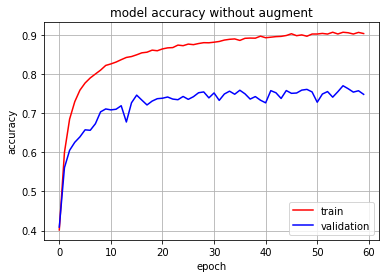

In [ ]:
model, hist = fit_model(model, train, label, test, test_label, "model_best_weights.h5", 1, bsize=64, title='without augment', eps=60)

#### Confusion Matrix

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

def eval_model(model, X_test, y_test, weights_name, title=''):
  # load weights
  model.load_weights(weights_name)
  # Compile model (required to make predictions)
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  # Prediction Labels
  y_pred = model.predict(X_test)
  y_pred = np.argmax(y_pred, axis=1)

  y_test_copy = np.argmax(y_test, axis=1)
  # Evaluate the trained model
  [test_loss, test_acc] = model.evaluate(X_test, y_test)
  print("Test Loss", test_loss)
  print("Test Accuracy", test_acc)
  # Confusion Matrix
  class_names=classes
  confusion_mtx = confusion_matrix(y_test_copy, y_pred)
      
  plot_confusion_matrix(confusion_mtx, class_names, title='Confusion matrix '+str(title))    

  print(classification_report(y_test_copy,y_pred))
  print('f1', f1_score(y_test_copy, y_pred, average='macro'))
  print('precision', precision_score(y_test_copy, y_pred, average='macro'))
  print('recall', recall_score(y_test_copy, y_pred, average='macro'))
  print('accuracy', accuracy_score(y_test_copy, y_pred))

313/313 [==============================] - 2s 4ms/step - loss: 0.8256 - accuracy: 0.7461
Test Loss 0.8340916037559509
Test Accuracy 0.7462999820709229
              precision    recall  f1-score   support

           0       0.75      0.86      0.80      1000
           1       0.91      0.93      0.92      1000
           2       0.68      0.69      0.68      1000
           3       0.61      0.26      0.37      1000
           4       0.69      0.78      0.73      1000
           5       0.76      0.30      0.43      1000
           6       0.69      0.92      0.79      1000
           7       0.66      0.91      0.76      1000
           8       0.84      0.91      0.87      1000
           9       0.85      0.90      0.87      1000

    accuracy                           0.75     10000
   macro avg       0.74      0.75      0.72     10000
weighted avg       0.74      0.75      0.72     10000

f1 0.7235767556224577
precision 0.7441134197103221
recall 0.7463
accuracy 0.7463


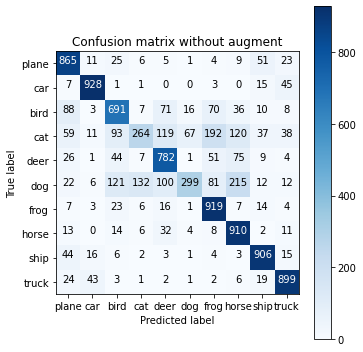

In [ ]:
eval_model(model, test, test_label, "model_best_weights.h5", 'without augment')

#### with augment

In [ ]:
def create_new(data,y):
  # expand dimension to one sample
  samples = data

  # create image data augmentation generator
  datagen = ImageDataGenerator(width_shift_range=0.2,
                              height_shift_range=0.2,
                              horizontal_flip=True, vertical_flip=True,
                              rotation_range=90,
                              brightness_range=[0.2,1.0],
                              zoom_range=[0.5,1.0])
  # prepare iterator
  it = datagen.flow(samples, y, batch_size=data.shape[0])
  res = []
  yres = []
  for j in range(9):
    # generate batch of images
    batch, ys = it.next()
    # convert to unsigned integers for viewing
    image = batch.astype('uint8')
    # print(batch.shape)
    # print(image.shape)
    res.append(image)
    yres.append(ys)
    # break
  
  return np.array(res), np.array(yres)

In [ ]:

c = []
d = []
for i, v in enumerate(label):
  if np.argmax(v)==3:
    c.append(i)
  elif np.argmax(v)==5:
    d.append(i)

print(len(c),len(d))

temp, ytemp = create_new(train[c], label[c])

temp1, ytemp1 = create_new(train[d], label[d])

train = np.vstack((train, temp.reshape(-1,32, 32, 3)))
label = np.vstack((label, ytemp.reshape(-1,10)))

train = np.vstack((train, temp1.reshape(-1,32, 32, 3)))
label = np.vstack((label, ytemp1.reshape(-1,10)))

500 500


In [ ]:
print(train.shape, label.shape)

(50000, 32, 32, 3) (50000, 10)


In [ ]:
from sklearn.utils import shuffle
train, label = shuffle(train, label, random_state=0)

#### fit model on augmented data

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 64)         

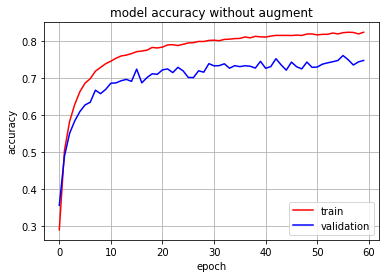

In [ ]:
model = create(nl=1, act='relu', opt='Adam', dcnv=True, drp=True, filter=[32,64,128],
                   kernel=[3,3,3], eln=[128,64], drp_v = [0.3, 0.3])

model, hist = fit_model(model, train, label, test, test_label, "model_best_weights.h5",
                        1, bsize=64, title='without augment', eps=60)

#### confusion matrix

313/313 [==============================] - 1s 4ms/step - loss: 0.8385 - accuracy: 0.7530
Test Loss 0.8424445390701294
Test Accuracy 0.753000020980835
              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1000
           1       0.93      0.88      0.90      1000
           2       0.62      0.75      0.68      1000
           3       0.67      0.23      0.35      1000
           4       0.66      0.84      0.74      1000
           5       0.72      0.41      0.52      1000
           6       0.69      0.91      0.78      1000
           7       0.75      0.86      0.80      1000
           8       0.88      0.90      0.89      1000
           9       0.82      0.92      0.87      1000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.73     10000
weighted avg       0.75      0.75      0.73     10000

f1 0.7344645631493587
precision 0.7536370713285152
recall 0.7529999999999999
accuracy 0.753

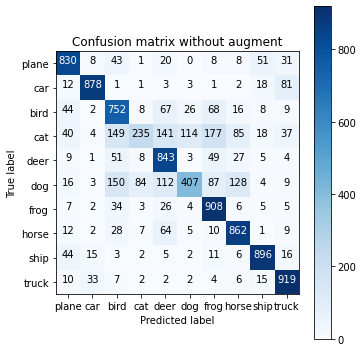

In [ ]:
eval_model(model, test, test_label, "model_best_weights.h5", 'without augment')